# Introduction

In this lab, we will explore two probabilistic models - Probabilistic PCA and Factor Analysis - and compare their effectiveness in model selection and covariance estimation. We will perform cross-validation on low rank data that is corrupted with homoscedastic or heteroscedastic noise. In addition, we will compare the model likelihood to the likelihoods obtained from shrinkage covariance estimators.

# Create the Data

We will create a simulated dataset that consists of 500 samples, 25 features, and a rank of 5. We will also add homoscedastic and heteroscedastic noise to the dataset.

In [1]:
import numpy as np
from scipy import linalg

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.0
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# Fit the Models

We will fit the Probabilistic PCA and Factor Analysis models to the dataset, and use cross-validation to evaluate their performance. We will also compute the scores for shrinkage covariance estimators, and compare the results.

best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 20
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 18


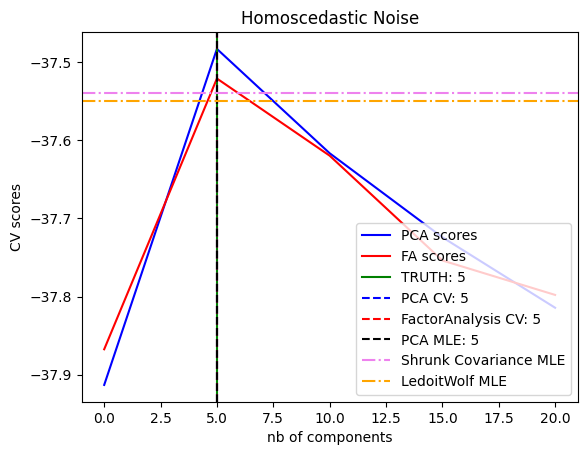

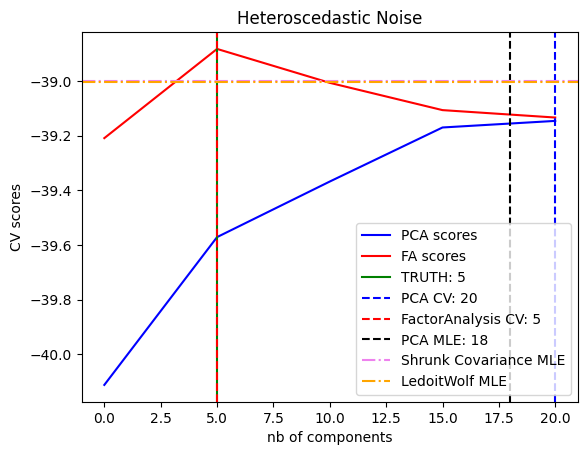

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score, GridSearchCV

n_components = np.arange(0, n_features, 5)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

for X, title in [(X_homo, "Homoscedastic Noise"), (X_hetero, "Heteroscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label="PCA scores")
    plt.plot(n_components, fa_scores, "r", label="FA scores")
    plt.axvline(rank, color="g", label="TRUTH: %d" % rank, linestyle="-")
    plt.axvline(
        n_components_pca,
        color="b",
        label="PCA CV: %d" % n_components_pca,
        linestyle="--",
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")
    plt.title(title)

plt.show()

# Summary

In this lab, we explored the effectiveness of Probabilistic PCA and Factor Analysis models in model selection and covariance estimation. We created a simulated dataset with homoscedastic and heteroscedastic noise, and compared the performance of the models using cross-validation. We also compared the model likelihood to the likelihoods obtained from shrinkage covariance estimators. The results showed that both PCA and FA were effective in recovering the size of the low rank subspace in the presence of homoscedastic noise. However, PCA failed and overestimated the rank when heteroscedastic noise was present. Under appropriate circumstances, the held-out data was more likely for low rank models than for shrinkage models.